# Lecture : Graph Generation Models

## Lab 06 : Diffusion model (DM) for QM9 molecular graphs

### Xavier Bresson


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd 
    !pip install rdkit==2023.09.6 # Install RDKit
    

In [2]:
# Libraries
import os
import time
from rdkit import Chem
from rdkit import RDLogger; RDLogger.DisableLog('rdApp.*')
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
import sys; sys.path.insert(0, 'lib/')
from lib.molecules import Dictionary, Molecule, from_pymol_to_smile

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.2.2
NVIDIA RTX A5000
cuda:0


## Loading molecular datasets (PyTorch format)

Loading data...
dataset/QM9_1.4k_pytorch/
Time: 0.5013449192047119
num train data : 1000
atom_dict.idx2word : ['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -']
atom_dict.word2idx : {'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
9 4
train[idx].atom_type : tensor([1, 1, 2, 1, 1, 1, 1])
train[idx].atom_type_pe : tensor([0, 1, 0, 2, 3, 4, 5])
train[idx].bond_type : tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]])
train[idx].bag_of_atoms : tensor([0, 6, 1, 0, 0, 0, 0, 0, 0])
train[idx].smile:  CC(O)C1CC1C


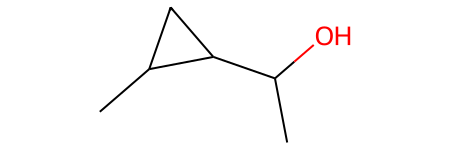

In [3]:
print('Loading data...') 
start = time.time()

data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test_pytorch.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val_pytorch.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print('num train data :',len(train)) 

print('atom_dict.idx2word :',atom_dict.idx2word)
print('atom_dict.word2idx :',atom_dict.word2idx)
print('bond_dict.idx2word :',bond_dict.idx2word)
print('bond_dict.word2idx :',bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 45
print('train[idx].atom_type :',train[idx].atom_type)
print('train[idx].atom_type_pe :',train[idx].atom_type_pe)
print('train[idx].bond_type :',train[idx].bond_type)
print('train[idx].bag_of_atoms :',train[idx].bag_of_atoms)
print('train[idx].smile: ',train[idx].smile)
mol = Chem.MolFromSmiles(train[idx].smile)
mol


## Print dataset statistics

In [4]:
# Organize data into group of of molecules of fixed sized
# Example: train[9] is a list containing all the molecules of size 9  
def group_molecules_per_size(dataset):
    mydict={}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)]=[]
        mydict[len(mol)].append(mol)
    return mydict
test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)
print(len(train_group[8])) # QM9

# largest size of molecule in the trainset
max_mol_sz = max(list( train_group.keys()))
print('Max num atoms = ', max_mol_sz)

# print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try: 
            print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
        except:
            pass
print('Train'); print_distribution(train_group)
print('Val'); print_distribution(val_group)
print('Test'); print_distribution(test_group)


136
Max num atoms =  9
Train
number of molecule of size 4: 	 1
number of molecule of size 5: 	 1
number of molecule of size 6: 	 7
number of molecule of size 7: 	 24
number of molecule of size 8: 	 136
number of molecule of size 9: 	 831
Val
number of molecule of size 7: 	 6
number of molecule of size 8: 	 28
number of molecule of size 9: 	 166
Test
number of molecule of size 6: 	 1
number of molecule of size 7: 	 3
number of molecule of size 8: 	 37
number of molecule of size 9: 	 159


## Generate batch of pytorch molecules of same size

In [5]:
# A class to help drawing batches of molecules with the same size
class MoleculeSampler:
    def __init__(self, organized_dataset, bs , shuffle=True):  
        self.bs = bs
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.counter = { sz: 0   for sz in organized_dataset }
        if shuffle:
            self.order = { sz: np.random.permutation(num)  for sz , num in self.num_mol.items() }
        else:
            self.order = { sz: np.arange(num)  for sz , num in self.num_mol.items() } 

    def compute_num_batches_remaining(self):
        return {sz:  math.ceil(((self.num_mol[sz] - self.counter[sz])/self.bs))  for sz in self.num_mol} 

    def choose_molecule_size(self):
        num_batches = self.compute_num_batches_remaining()
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   ) 
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum( num_batches.values() ) == 0

    def draw_batch_of_molecules(self, sz):  
        num_batches = self.compute_num_batches_remaining()
        if (self.num_mol[sz] - self.counter[sz])/self.bs >= 1.0:
            bs = self.bs
        else:
            bs = self.num_mol[sz] - (self.num_mol[sz]//self.bs) * self.bs
        #print('sz, bs',sz, bs)
        indices = self.order[sz][ self.counter[sz] : self.counter[sz] + bs]
        self.counter[sz] += bs 
        return indices

# extract one mini-batch
bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
while(not sampler.is_empty()):
    num_batches_remaining = sampler.compute_num_batches_remaining()
    print('num_batches_remaining :',num_batches_remaining)
    sz = sampler.choose_molecule_size()
    print('sz :',sz)
    indices = sampler.draw_batch_of_molecules(sz) 
    print('indices :',len(indices),indices)
    minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] )
    print('minibatch_node :',minibatch_node.size())
    minibatch_pe  = torch.stack( [ train_group[sz][i].atom_type_pe  for i in indices] )
    print('minibatch_pe :',minibatch_pe.size())
    minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] )
    print('minibatch_edge :',minibatch_edge.size())
    minibatch_boa = torch.stack( [ train_group[sz][i].bag_of_atoms for i in indices] )
    print('minibatch_boa :',minibatch_boa.size())
    break
    print('---------------------------------------')


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 9
indices : 50 [171 496 801 637 583 639 606 446  91   6  57 782 349 212 784 360 603 490
 741 137 670 362 408 254 688  70 544 683 332 398 336 114  68 363 513 522
  48 104 162 195 361 768 615 164 294 422 239 523  30  13]
minibatch_node : torch.Size([50, 9])
minibatch_pe : torch.Size([50, 9])
minibatch_edge : torch.Size([50, 9, 9])
minibatch_boa : torch.Size([50, 9])


## Sample molecule size

In [6]:
# A class to sample a molecule size w.r.t. the train distribution
class sample_molecule_size:
    def __init__(self, organized_dataset):  
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.num_batches_remaining = { sz:  self.num_mol[sz]  for sz in self.num_mol } 
    def choose_molecule_size(self):
        num_batches = self.num_batches_remaining
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   ) 
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz
        
sampler_size = sample_molecule_size(train_group)
print('sampler_size.num_mol :',sampler_size.num_mol)
sz = sampler_size.choose_molecule_size()
print('sz :',sz)


sampler_size.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
sz : 9


# Diffusion model (DDPM) [1] with Graph Transformers [2]

[1] Ho et-al, Denoising Diffusion Probabilistic Models, 2020, https://arxiv.org/pdf/2006.11239   
[2] Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020, https://arxiv.org/pdf/2012.09699.pdf  


In [7]:
# Global constants
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers = 6 # number of transformer layers
dPEt = d # number of dimensions for the time step of the diffusion model
drop = 0.0 # dropout value
bs = 10 # batch size

print('num_heads, d, num_layers, dPEt, drop, bs : ', num_heads, d, num_layers, dPEt, drop, bs)

beta_1 = 0.0001 # beta_1 for DM
beta_T = 0.02 # beta_T for DM
num_t = 150 # number of time steps of the DM
alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # for DM, size=[num_t] 
alpha_bar_t = torch.cumprod( alpha_t, dim=0) # for DM, size=[num_t] 
print('beta_1, beta_T, num_t :', beta_1, beta_T, num_t)

# Warmup 
num_mol_size = 20
num_warmup = 2 * max( num_mol_size, len(train) // bs ) # 4 epochs * max( num_mol_size=20, num_mol/batch_size)
print('num_warmup :',num_warmup)


num_heads, d, num_layers, dPEt, drop, bs :  4 128 6 128 0.0 10
beta_1, beta_T, num_t : 0.0001 0.02 150
num_warmup : 200


In [8]:
# Define DDPM architecture with Graph Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)
    def forward(self, x, e):
        Q = self.Q(x) # [bs, n, d_head]
        K = self.K(x) # [bs, n, d_head]
        V = self.V(x) # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        E = self.E(e) # [bs, n, n, d_head]
        Ni = self.Ni(x).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(x).unsqueeze(1) # [bs, 1, n, d_head]
        e = Ni + Nj + E              # [bs, n, n, d_head]
        Att = (Q * e * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)            # [bs, n, n]
        Att = self.drop_att(Att)                   # [bs, n, n]
        x = Att @ V                  # [bs, n, d_head]
        return x, e                  # [bs, n, d_head], [bs, n, n, d_head]

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.WOe = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
        self.drop_e = nn.Dropout(drop)
    def forward(self, x, e):
        x_MHA = []
        e_MHA = []    
        for head in self.heads:
            x_HA, e_HA = head(x,e)            # [bs, n, d_head], [bs, n, n, d_head]
            x_MHA.append(x_HA)
            e_MHA.append(e_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        e = self.WOe(torch.cat(e_MHA, dim=3)) # [bs, n, n, d]
        e = self.drop_e(e)                    # [bs, n, n, d]
        return x, e                           # [bs, n, d], [bs, n, n, d]

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNe = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.LNe2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.MLPe = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.drop_e_mlp = nn.Dropout(drop)
    def forward(self, x, e):
        x = self.LNx(x)                 # [bs, n, d]
        e = self.LNe(e)                 # [bs, n, n, d]
        x_MHA, e_MHA = self.MHA(x, e)   # [bs, n, d], [bs, n, n, d]
        x = x + x_MHA                   # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        e = e + e_MHA                   # [bs, n, n, d]
        e = e + self.MLPe(self.LNe2(e)) # [bs, n, n, d]
        e = self.drop_e_mlp(e)          # [bs, n, n, d]
        return x, e                     # [bs, n, d], [bs, n, n, d]

def sym_tensor(x):
    x = x.permute(0,3,1,2) # [bs, d, n, n]
    triu = torch.triu(x,diagonal=1).transpose(3,2) # [bs, d, n, n]
    mask = (triu.abs()>0).float()                  # [bs, d, n, n]
    x =  x * (1 - mask ) + mask * triu             # [bs, d, n, n]
    x = x.permute(0,2,3,1) # [bs, n, n, d]
    return x               # [bs, n, n, d]

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(max_mol_sz, d)
        self.atom_emb = nn.Linear(num_atom_type, d)
        self.bond_emb = nn.Linear(num_bond_type, d)
        self.pe_t_emb = nn.Sequential(nn.Embedding(num_t, dPEt), nn.ReLU(), nn.Linear(dPEt, d))
        self.gt_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers)] )
        self.atom_dec = nn.Linear(d, num_atom_type)
        self.bond_dec = nn.Linear(d, num_bond_type)
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_e_emb = nn.Dropout(drop)
        self.drop_p_emb = nn.Dropout(drop)
    def forward(self, x_t, e_t, sample_t):
        bs2 = x_t.size(0); n = x_t.size(1) 
        pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n]  
        pe_x = self.pe_x(pe_x)                            # [bs, n, d]  
        x_t = self.atom_emb(x_t)                          # [bs, n, d]
        x_t = x_t + pe_x                                  # [bs, n, d]
        e_t = self.bond_emb(e_t)                   # [bs, n, n, d]
        e_t = e_t + pe_x.unsqueeze(1) + pe_x.unsqueeze(2) # [bs, n, n, d]  
        e_t = sym_tensor(e_t)                      # [bs, n, n, d]
        p_t = self.pe_t_emb(sample_t)              # [bs, d]
        x_t = self.drop_x_emb(x_t)                 # [bs, n, d] 
        e_t = self.drop_e_emb(e_t)                 # [bs, n, n, d]
        p_t = self.drop_p_emb(p_t)                 # [bs, d]
        for gt_layer in self.gt_layers:
            x_t = x_t + p_t.unsqueeze(1)               # [bs, n, d]
            e_t = e_t + p_t.unsqueeze(1).unsqueeze(2)  # [bs, n, n, d] 
            x_t, e_t = gt_layer(x_t, e_t)          # [bs, n, d], [bs, n, n, d] 
            e_t = sym_tensor(e_t)                  # [bs, n, n, d] 
        x_t_minus_one = self.atom_dec(x_t)         # [bs, n, num_atom_type]
        e_t_minus_one = self.bond_dec(e_t)         # [bs, n, n, num_bond_type]
        return x_t_minus_one, e_t_minus_one

class DDPM(nn.Module):

    def __init__(self, num_t, beta_1, beta_T):
        super().__init__()
        self.num_t = num_t
        self.alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # [num_t]
        self.alpha_bar_t = torch.cumprod( self.alpha_t, dim=0) # [num_t]
        self.UNet = UNet()

    def forward_process(self, x0, e0, sample_t, noise_x0, noise_e0): # add noise
        x0 = torch.nn.functional.one_hot(x0, num_atom_type) # one hot encoding
        e0 = torch.nn.functional.one_hot(e0, num_bond_type) # one hot encoding
        bs2 = len(sample_t)
        sqrt_alpha_bar_t = self.alpha_bar_t[sample_t].sqrt() # [bs]
        sqrt_one_minus_alpha_bar_t = ( 1.0 - self.alpha_bar_t[sample_t] ).sqrt() # [bs]
        x_t = sqrt_alpha_bar_t.view(bs2,1,1) * x0 + sqrt_one_minus_alpha_bar_t.view(bs2,1,1) * noise_x0 # [bs, n, n_atom]
        e_t = sqrt_alpha_bar_t.view(bs2,1,1,1) * e0 + sqrt_one_minus_alpha_bar_t.view(bs2,1,1,1) * noise_e0 # [bs, n, n, n_bond]
        return x_t, e_t

    def backward_process(self, x_t, e_t, sample_t): # denoise
        x_t_minus_one, e_t_minus_one = self.UNet(x_t, e_t, sample_t) # [bs, 28, 28]
        return x_t_minus_one, e_t_minus_one

    def generate_process_ppdm(self, num_mol, size_mol):
        t = num_t - 1
        bs2 = num_mol
        n = size_mol
        batch_t = (t * torch.ones(bs2)).long().to(device)
        batch_x_t = torch.randn(bs2, n, num_atom_type).to(device) # t=T => t=T-1 in python
        batch_e_t = torch.randn(bs2, n, n, num_bond_type).to(device) # t=T => t=T-1 in python
        batch_e_t = sym_tensor(batch_e_t) 
        set_t = list(range(t-1,0,-1)); set_t = set_t + [0]
        #print('num_steps:',len(set_t)+1,'set_t:',set_t)
        for t_minus_one in set_t: # for t=T,T-step_size,T-2*step_size,...,step_size,0
            batch_t_minus_one = (t_minus_one * torch.ones(bs2)).long().to(device)
            batch_noise_pred_x_t, batch_noise_pred_e_t = self.backward_process(batch_x_t, batch_e_t, batch_t)
            sigma_t = ( (1.0-self.alpha_bar_t[t_minus_one])/ (1.0-self.alpha_bar_t[t])* (1.0-self.alpha_bar_t[t]/self.alpha_bar_t[t_minus_one]) ).sqrt()
            c1 = self.alpha_bar_t[t_minus_one].sqrt() / self.alpha_bar_t[t].sqrt()
            c2 = ( 1.0 - self.alpha_bar_t[t] + 1e-10 ).sqrt()
            c3 = ( 1.0 - self.alpha_bar_t[t_minus_one] - sigma_t.square() + 1e-10 ).sqrt()
            batch_x_t_minus_one = c1 * ( batch_x_t - c2 * batch_noise_pred_x_t ) + \
                c3 * batch_noise_pred_x_t + sigma_t* torch.randn(bs2, n, num_atom_type).to(device)
            noise_e_t = torch.randn(bs2, n, n, num_bond_type).to(device)
            noise_e_t = sym_tensor(noise_e_t)
            batch_e_t_minus_one = c1 * ( batch_e_t - c2 * batch_noise_pred_e_t ) + \
                c3 * batch_noise_pred_e_t + sigma_t* noise_e_t
            t = t_minus_one
            batch_x_t = batch_x_t_minus_one
            batch_e_t = batch_e_t_minus_one
            batch_t = batch_t_minus_one
        return batch_x_t, batch_e_t


try:
    del net
    torch.cuda.empty_cache()
except:
  print("First run")


# Instantiate the network
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.AdamW(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :',num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :',sz)
indices = sampler.draw_batch_of_molecules(sz) 
#print('indices :',len(indices),indices)
batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
print('minibatch_node :',minibatch_node.size())
batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
print('minibatch_edge :',minibatch_edge.size())
batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
print('batch_sample_t',batch_sample_t.size())

bs2, n = batch_x0.size()
batch_noise_x_t = torch.randn(bs2,n,num_atom_type).to(device) # [bs, n, num_atom_type]
batch_noise_e_t = torch.randn(bs2,n,n,num_bond_type).to(device) # [bs, n, n, num_bond_type]
batch_noise_e_t = sym_tensor(batch_noise_e_t)  

print('batch_noise_x_t',batch_noise_x_t.size(),'batch_noise_e_t',batch_noise_e_t.size())
x_t, e_t = net.forward_process(batch_x0, batch_e0, batch_sample_t, batch_noise_x_t, batch_noise_e_t) # [bs, n], [bs, n, n]
print('x_t',x_t.size(), 'e_t',e_t.size())

noise_pred_x_t, noise_pred_e_t = net.backward_process(x_t, e_t, batch_sample_t) # [bs, n], [bs, n, n]
print('noise_pred_x_t',noise_pred_x_t.size(),'noise_pred_e_t',noise_pred_e_t.size())

loss_PPDM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t) + 1.0* torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
loss = loss_PPDM
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25) # grad_norm_clip=1.0
optimizer.step()

with torch.no_grad():
    batch_x_0, batch_e_0 = net.generate_process_ppdm(4, 9)
    print('batch_x_0',batch_x_0.size(), 'batch_e_0',batch_e_0.size())



First run
Number of parameters: 2419725 (2.42 million)


/home/deeplearn/miniconda3/envs/gnn_course_gpu/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 84, 8: 14, 7: 3, 6: 1, 5: 1, 4: 1}
sz : 9
minibatch_node : torch.Size([10, 9])
minibatch_edge : torch.Size([10, 9, 9])
batch_sample_t torch.Size([10])
batch_noise_x_t torch.Size([10, 9, 9]) batch_noise_e_t torch.Size([10, 9, 9, 4])
x_t torch.Size([10, 9, 9]) e_t torch.Size([10, 9, 9, 4])
noise_pred_x_t torch.Size([10, 9, 9]) noise_pred_e_t torch.Size([10, 9, 9, 4])
batch_x_0 torch.Size([4, 9, 9]) batch_e_0 torch.Size([4, 9, 9, 4])


In [9]:
# Training loop
del net
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.AdamW(net.parameters(), lr=init_lr)
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/num_warmup, 1.0) ) # warmup scheduler
scheduler_tracker = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True) # tracker scheduler

# Number of mini-batches per epoch
nb_epochs = 1000
num_warmup_batch = 0
print('num_heads, d, num_layers, dPEt, drop, bs : ', num_heads, d, num_layers, dPEt, drop, bs)
print('beta_1, beta_T, num_t :', beta_1, beta_T, num_t)
print('num_warmup, nb_epochs :',num_warmup, nb_epochs)

start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    net.train()

    sampler = MoleculeSampler(train_group, bs)
    count = 0
    while(not sampler.is_empty()):

        sz = sampler.choose_molecule_size()
        indices = sampler.draw_batch_of_molecules(sz) 
        batch_x0 = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
        batch_e0 = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
        batch_sample_t = torch.randint(0, num_t, (batch_x0.size(0),)).long().to(device) # random interger in {0,1,...,T-1} [bs]
        bs2, n = batch_x0.size()
        batch_noise_x_t = torch.randn(bs2,n,num_atom_type).to(device) # [bs, n, num_atom_type]
        batch_noise_e_t = torch.randn(bs2,n,n,num_bond_type).to(device) # [bs, n, n, num_bond_type]
        batch_noise_e_t = sym_tensor(batch_noise_e_t)  
        x_t, e_t = net.forward_process(batch_x0, batch_e0, batch_sample_t, batch_noise_x_t, batch_noise_e_t) # [bs, n], [bs, n, n]
        noise_pred_x_t, noise_pred_e_t = net.backward_process(x_t, e_t, batch_sample_t) # [bs, n], [bs, n, n]
        loss_PPDM = torch.nn.MSELoss()(noise_pred_x_t, batch_noise_x_t) + 1.0* torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
        loss = loss_PPDM
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25) # grad_norm_clip=1.0
        optimizer.step()

        if num_warmup_batch < num_warmup:
            scheduler_warmup.step() # warmup scheduler
        num_warmup_batch += 1

        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1 
        
        
    # Average stats
    mean_loss = running_loss/ num_batches       
    if num_warmup_batch >= num_warmup:
        scheduler_tracker.step(mean_loss) # tracker scheduler defined w.r.t. loss value
    elapsed = (time.time()-start)/60    
    if not epoch%5:
        print('epoch= %d \t time= %.4f min \t lr= %.7f \t loss= %.4f' % (epoch, elapsed, optimizer.param_groups[0]['lr'], mean_loss) )

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-6: 
      print("\n lr is equal to min lr -- training stopped\n") 
      break
        


Number of parameters: 2419725 (2.42 million)
num_heads, d, num_layers, dPEt, drop, bs :  4 128 6 128 0.0 10
beta_1, beta_T, num_t : 0.0001 0.02 150
num_warmup, nb_epochs : 200 1000
epoch= 0 	 time= 0.0903 min 	 lr= 0.0001575 	 loss= 2.0219
epoch= 5 	 time= 0.5336 min 	 lr= 0.0003000 	 loss= 0.3566
epoch= 10 	 time= 0.9768 min 	 lr= 0.0003000 	 loss= 0.2547
epoch= 15 	 time= 1.4206 min 	 lr= 0.0003000 	 loss= 0.1993
epoch= 20 	 time= 1.8654 min 	 lr= 0.0003000 	 loss= 0.1675
epoch= 25 	 time= 2.3067 min 	 lr= 0.0002850 	 loss= 0.1487
epoch= 30 	 time= 2.7483 min 	 lr= 0.0002707 	 loss= 0.1255
epoch= 35 	 time= 3.1908 min 	 lr= 0.0002444 	 loss= 0.1355
epoch= 40 	 time= 3.6309 min 	 lr= 0.0002321 	 loss= 0.1185
epoch= 45 	 time= 4.0730 min 	 lr= 0.0002095 	 loss= 0.1067
epoch= 50 	 time= 4.5157 min 	 lr= 0.0001990 	 loss= 0.1021
epoch= 55 	 time= 4.9594 min 	 lr= 0.0001891 	 loss= 0.1145
epoch= 60 	 time= 5.4083 min 	 lr= 0.0001706 	 loss= 0.0980
epoch= 65 	 time= 5.8518 min 	 lr= 0.0001

## Compute percentage of valid molecules

In [10]:
# compute percentage of valid molecules
def compute_perc_valid_molecules(net, sampler_size, num_gen_mol=1000, num_generated_mols_per_batch=100):
    num_atom = 9 # QM9
    num_batches = num_gen_mol // num_generated_mols_per_batch 
    num_valid_mol = 0
    list_valid_mol = []
    list_mol = []
    start = time.time()
    for idx in range(num_batches):
        net.eval()
        with torch.no_grad():  
            num_atom_sampled = sampler_size.choose_molecule_size() # sample the molecule size
            num_atom_sampled = num_atom # same size
            batch_x_0, batch_e_0 = net.generate_process_ppdm(num_generated_mols_per_batch, num_atom_sampled)
            batch_x_0 = torch.max(batch_x_0, dim=2)[1]  # [bs, n]
            batch_e_0 = torch.max(batch_e_0, dim=3)[1] # [bs, n, n]
            x_hat = batch_x_0.detach().to('cpu')
            e_hat = batch_e_0.detach().to('cpu')
            for x,e in zip(x_hat,e_hat):
                pymol = Molecule(num_atom_sampled, num_atom_type)
                pymol.atom_type = x
                pymol.bond_type = e
                smile = from_pymol_to_smile(pymol, atom_dict, bond_dict)
                list_mol.append(smile)
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    list_valid_mol.append(smile)
                    num_valid_mol += 1
    perc_valid_molecules = 100*num_valid_mol/num_gen_mol
    line = '\t num_gen_mol= ' + str(num_gen_mol) + '   time(min)= ' + str((time.time()-start)/60)[:5] + '   perc valid molecules= ' + str(perc_valid_molecules)[:6]
    return perc_valid_molecules, list_mol, line, list_valid_mol

perc_valid_mol, list_mol, line, list_valid_mol = compute_perc_valid_molecules(net, sampler_size)
print('percentage of valid molecules')
print(line)
print(list_valid_mol[:10]) 

 

percentage of valid molecules
	 num_gen_mol= 1000   time(min)= 0.289   perc valid molecules= 41.5
['C=CCC1=C(O)CCN1', 'CCC12CCNC1CC2', 'CCC(C)CCO.CO', 'OC12CC34C(CCC13)C24', 'CCNC12C3OC1(C)N32', 'CC(=O)C(O)C1NCN1', 'CC1C2CC=C(C2)C1O', 'NC1(CO)C2C3OC3C21', 'N=C1N2CC3(N)N2C13O', 'CCCC(C)CO.CN']


## Plot a few molecules

tensor([339, 116,  23, 301, 237, 187,  81, 197, 351, 243, 110, 230, 259, 182,
        153, 250])


<Figure size 1280x960 with 0 Axes>

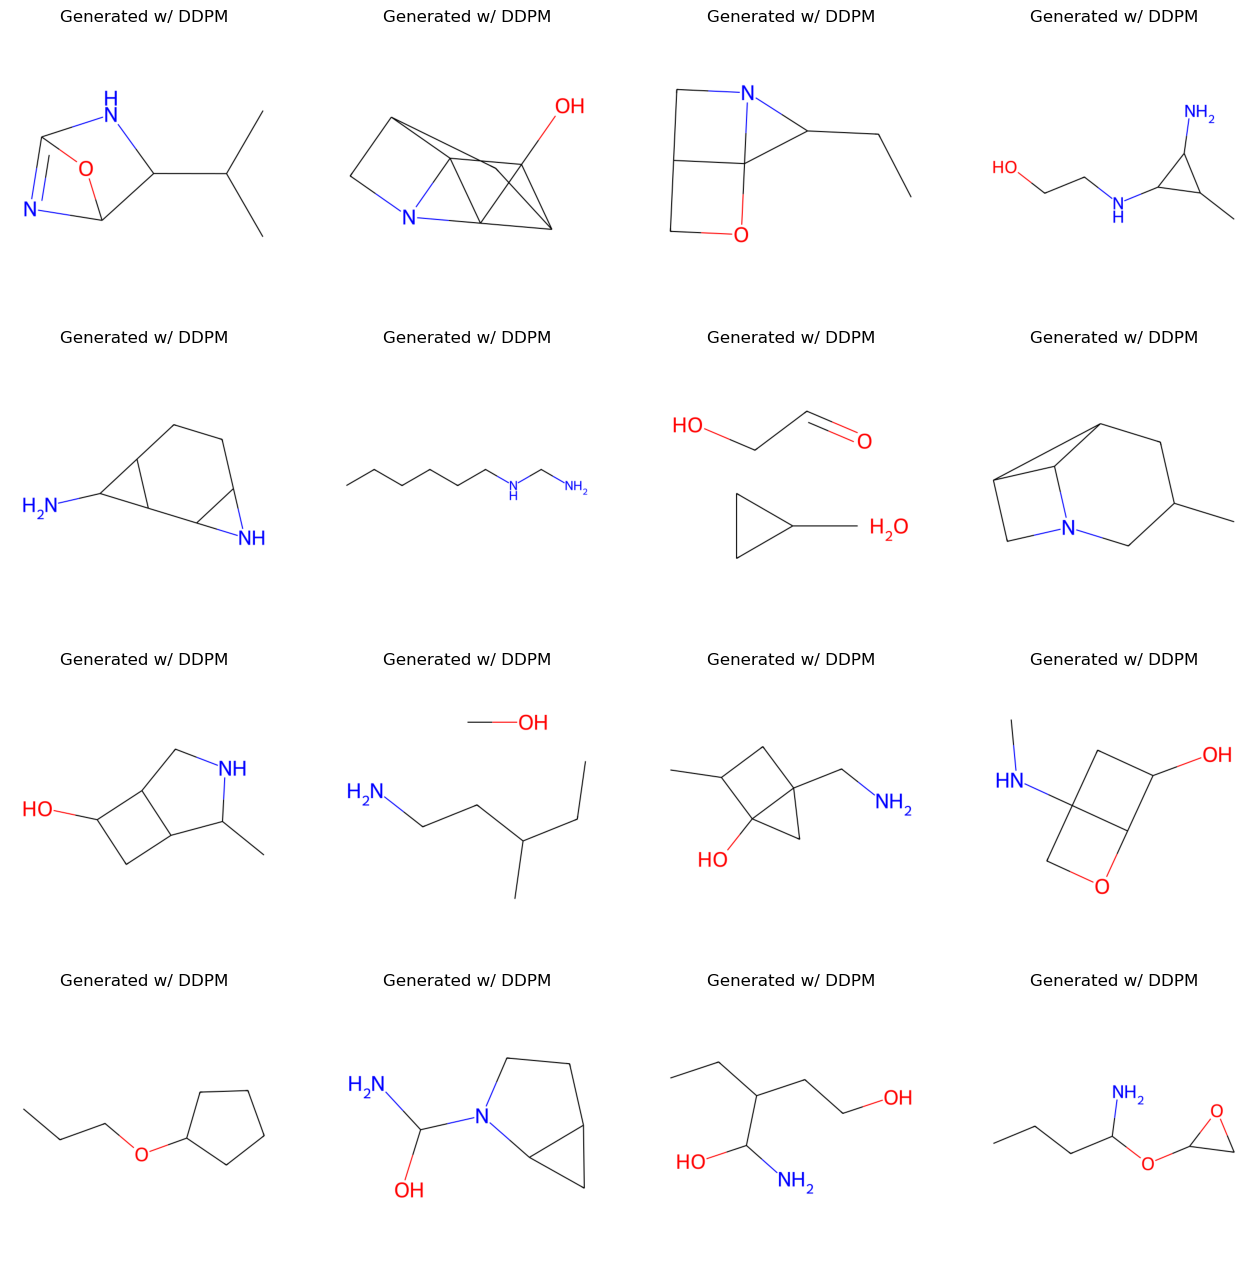

In [11]:
num_valid_mol = len(list_valid_mol)
num_print_mol = 16
list_idx = torch.randperm(num_valid_mol)[:num_print_mol] 
print(list_idx)

from rdkit.Chem import Draw
list_valid_mol_img = [ Draw.MolToImage(Chem.MolFromSmiles(list_valid_mol[idx]),size=(512, 512)) for idx in list_idx ]

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,0,1; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,0,2; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,0,3; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,1+0,4; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,1+0,5; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,1+0,6; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,1+0,7; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,2+0,8; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,2+0,9; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,2+0,10; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,2+0,11; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,3+0,12; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,3+0,13; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,3+0,14; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,3+0,15; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
plt.show() 


## Percentage of unique molecules among the generated molecules

In [12]:
print('num_generated_mol',len(list_mol))
num_unique_mol = 0
for idx,mol in enumerate(list_mol):
    list_tmp = list_mol.copy()
    list_tmp.pop(idx)
    if mol not in list_tmp:
        num_unique_mol += 1
print('num_unique_mol, num_mol:',num_unique_mol, len(list_mol))
perc_unique_mol = 100*num_unique_mol/len(list_mol)
print('perc unique molecules among the generated molecules:', str(perc_unique_mol)[:6])


num_generated_mol 1000
num_unique_mol, num_mol: 998 1000
perc unique molecules among the generated molecules: 99.8


## Percentage of novel molecules (not present in the training set)

In [13]:
list_train_mol = [] 
for idx in range(len(train)):
    list_train_mol.append(train[idx].smile) 
print('num_train_mol',len(list_train_mol))
print(list_train_mol[:10])
num_unique_mol = 0
for mol in list_mol:
    if mol not in list_train_mol:
        num_unique_mol += 1
print('num_unique_mol, num_mol:',num_unique_mol, len(list_mol))
perc_novel_mol = 100 * num_unique_mol / len(list_mol)
print('perc of novelty:', str(perc_novel_mol)[:6])


num_train_mol 1000
['CC1C(O)C2C(O)CC12', 'N#CCC1=CC(N)=NO1', 'CC1CCC1NCC#N', 'OC1CNC2=C1C=CO2', 'O=CC12NC3C4C1N4C32', 'C1=CC2=C(C=NN2)NC1', 'C1CC23CCC2OCC13', 'C1OCC12NCC21CO1', 'NC1=NC=C(F)C=C1O', 'ON=C1C2CC3C1CC23']
num_unique_mol, num_mol: 1000 1000
perc of novelty: 100.0


## Compare results

| Generative technique    | Validity (%) | Uniqueness (%) | Novelty (%) |
| -------- | ------- | ------- | ------- |
| VAE   | 78.4    | 86.9    |  93.1    |
| WGAN  | 66.5    | 68.8    |  100.0    |
| DDPM  | 41.5    | 100.0    |  100.0    |
